In [1]:
# run the script initnotebook.py in the cuurent folder
# Error when run multiple times becasue the directory changed
%run initnotebook.py

current working dir/home/abjawad/Documents/GitHub/local-attention-model


In [2]:
import torch
from  torch.utils.data import DataLoader
import torch.nn as nn
from models.builder import EncoderDecoder as segmodel
from dataloader.cfg_defaults import get_cfg_defaults
from config_cityscapes import *
import os
from dataloader.cityscapes_dataloader import CityscapesDataset
from val_segformer_rgbonly import val_cityscape

import torch.nn.functional as F
from utils.visualize import unnormalize_img_numpy

In [3]:
from visualizer.visualizer import *

In [4]:
output_dir = '/home/abjawad/Documents/GitHub/local-attention-model/visualizer/images'
if os.path.exists(output_dir):
    print('Output directory exists')

Output directory exists


In [5]:
# # # create a random image tensor of torch.Size([1, 64, 256, 256]) and save it
# img = torch.rand(1, 64, 256, 256)

# save_after_block(img, 'average', output_dir)

In [6]:
config_path = 'dataloader/cityscapes_rgbd_config.yaml'
config_path = os.path.join(projectFolder, config_path)

cfg = get_cfg_defaults()
cfg.merge_from_file(config_path)
cfg.freeze()

data_mean = [0.291,  0.329,  0.291]
data_std = [0.190,  0.190,  0.185]

In [7]:
cityscapes_test = CityscapesDataset(cfg, split='val')
test_loader = DataLoader(cityscapes_test, batch_size=1, shuffle=False, num_workers=4) # batchsize?
print(f'total test sample: {len(cityscapes_test)} v_iteration:{len(test_loader)}')


Using RGB input
Using RGB input
Found 500 val images
total test sample: 500 v_iteration:500


In [8]:
pretrained_model_path = './pretrained/model_400.pth'
criterion = nn.CrossEntropyLoss(reduction='mean', ignore_index=config.background)

model = segmodel(cfg=config, criterion=criterion, norm_layer=nn.BatchNorm2d, test=True)
model = nn.DataParallel(model, device_ids = config.device_ids)
# model.to(f'cuda:{model.device_ids[0]}', non_blocking=True)

28 18:50:46 Using backbone: Segformer-B2
28 18:50:46 Using MLP Decoder


In [9]:
saved_model_path = os.path.join(projectFolder, pretrained_model_path)
print(saved_model_path)
# exit()
state_dict = torch.load(saved_model_path)
model.load_state_dict(state_dict['model'], strict=False)
print(f'model loaded')
epoch = state_dict['epoch']


/home/abjawad/Documents/GitHub/local-attention-model/./pretrained/model_400.pth


model loaded


In [10]:
# val_loss, val_mean_iou = val_cityscape(epoch, test_loader, model)

In [11]:
import matplotlib.pyplot as plt

def plot_output(img, gt, out):
    # Plot the input image (RGB)
    plt.figure(figsize=(5, 5))
    plt.imshow(img[0].permute(1, 2, 0).cpu().numpy())
    plt.title('Input Image')
    plt.show()

    # Plot the ground truth (GT)
    plt.figure(figsize=(5, 5))
    plt.imshow(gt[0].cpu().numpy(), cmap='viridis')
    plt.title('Ground Truth')
    plt.show()

    # Convert the output tensor to NumPy and plot the available output channels separately
    out = out[1].cpu().numpy()
    _, axes = plt.subplots(4, 5, figsize=(15, 12))

    # Loop through the 19 channels and plot them
    for i in range(19):
        row, col = divmod(i, 5)  # Calculate the row and column for each subplot
        ax = axes[row, col]  # Get the corresponding subplot
        channel_data = out[0, i, :, :]
        ax.imshow(channel_data, cmap='viridis')  # You can change the colormap as needed
        ax.set_title(f'Channel {i + 1}')  # Set a title for the subplot
    plt.tight_layout()
    plt.show()


model.eval()
with torch.no_grad():
    for idx, sample in enumerate(test_loader):
        imgs = sample['image']      #B, 3, 1024, 2048
        gts = sample['label']       #B, 1024, 2048
        imgs = imgs.to(f'cuda:{model.device_ids[0]}', non_blocking=True)
        gts = gts.to(f'cuda:{model.device_ids[0]}', non_blocking=True)

        img = imgs[:, :, :, :1024]
        gt = gts[:, :, :1024]
        loss, out, atten = model(img, gt, visualize=True, attention=True)
        print('loss = ', loss.shape)
        print('out = ', out.shape)
        print('atten = ', len(atten))
        # plot_output(img, gt, out)

        print(img.shape, gt.shape)
        # print(len(out), out[0].shape, out[1].shape)
        break

# tokenization:  torch.Size([1, 65536, 64])
# tokenization:  torch.Size([1, 16384, 128])
# tokenization:  torch.Size([1, 4096, 320])
# tokenization:  torch.Size([1, 1024, 512])

input:  torch.Size([1, 3, 1024, 1024])
tokenization:  torch.Size([1, 65536, 64])
Image saved at /home/abjawad/Documents/GitHub/local-attention-model/check_output/patch_embed_1/63.jpg shape:(256, 256)
Image saved at /home/abjawad/Documents/GitHub/local-attention-model/check_output/patch_embed_2/127.jpg shape:(128, 128)
Image saved at /home/abjawad/Documents/GitHub/local-attention-model/check_output/patch_embed_3/319.jpg shape:(64, 64)
Image saved at /home/abjawad/Documents/GitHub/local-attention-model/check_output/patch_embed_4/511.jpg shape:(32, 32)
loss =  torch.Size([])
out =  torch.Size([1, 19, 1024, 1024])
atten =  4
torch.Size([1, 3, 1024, 1024]) torch.Size([1, 1024, 1024])


In [12]:
attention = atten
image = img

print(image.shape)
print(len(attention))

torch.Size([1, 3, 1024, 1024])
4


In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def get_attention_matrix(attention, layer, head):
    # sanity check
    if layer >= len(attention):
        print('layer index out of range')
        return None
    if head >= len(attention[layer]):
        print('head index out of range')
        return None
    atten = attention[layer][head]
    return atten

def plot_attention_matrix_for_index(attention, i):
    atten = attention[i]
    # plot 2D matrix of attention using matplotlib
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Attention Matrix')
    ax.imshow(atten, cmap='viridis')
    plt.show()
    pass

for i in range(len(attention)):
    for j in range(len(attention[i])):
        print('attention layer', i, 'head ', j+1, attention[i][j].shape)


attention layer 0 head  1 torch.Size([256, 256, 256])
attention layer 0 head  2 torch.Size([1024, 64, 64])
attention layer 1 head  1 torch.Size([64, 256, 256])
attention layer 1 head  2 torch.Size([256, 64, 64])
attention layer 1 head  3 torch.Size([256, 64, 64])
attention layer 1 head  4 torch.Size([1024, 16, 16])
attention layer 2 head  1 torch.Size([256, 16, 16])
attention layer 2 head  2 torch.Size([256, 16, 16])
attention layer 2 head  3 torch.Size([1024, 4, 4])
attention layer 2 head  4 torch.Size([1024, 4, 4])
attention layer 2 head  5 torch.Size([1, 1, 4096, 4096])
attention layer 3 head  1 torch.Size([256, 4, 4])
attention layer 3 head  2 torch.Size([256, 4, 4])
attention layer 3 head  3 torch.Size([256, 4, 4])
attention layer 3 head  4 torch.Size([256, 4, 4])
attention layer 3 head  5 torch.Size([1, 1, 1024, 1024])
attention layer 3 head  6 torch.Size([1, 1, 1024, 1024])
attention layer 3 head  7 torch.Size([1, 1, 1024, 1024])
attention layer 3 head  8 torch.Size([1, 1, 1024,

In [14]:
head = 0
layer = 0
atten = get_attention_matrix(attention, layer, head)

# convert to numpy
atten = atten.cpu().numpy()
print(atten.shape)


(256, 256, 256)


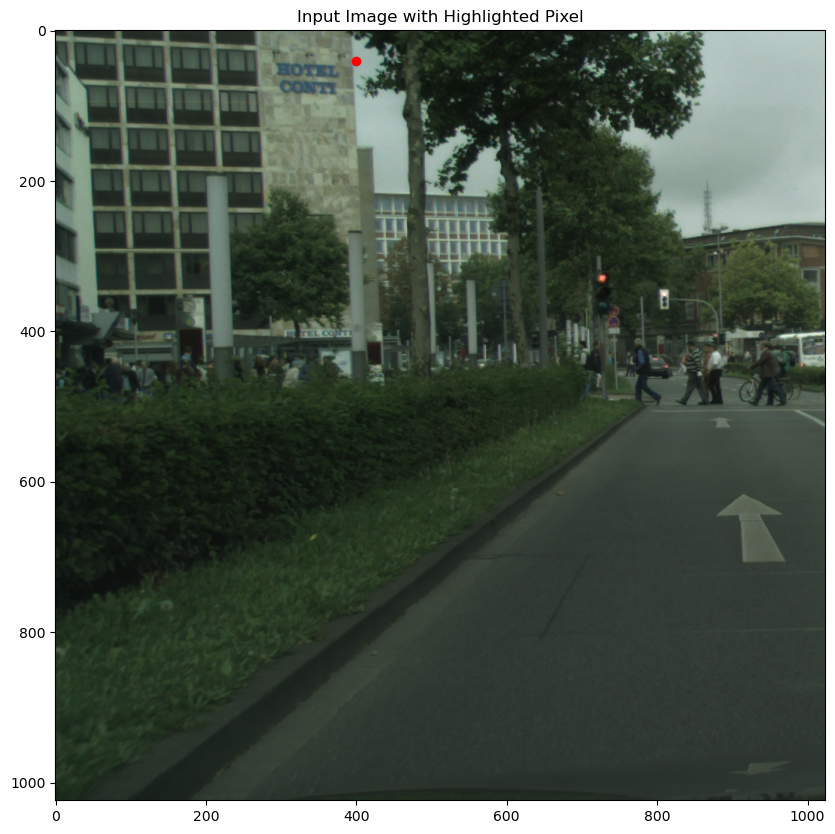

In [15]:
pixel = (400, 40)
downsample_factor = 4

# Convert the tensor to a NumPy array
# image_array = image[0].permute(1, 2, 0).cpu().numpy()
image = unnormalize_img_numpy(image)
image_array = image
# Plot the image
plt.figure(figsize=(10, 10))
plt.imshow(image_array)

# Highlight the pixel at (100, 100) in red
plt.scatter(pixel[0], pixel[1], c='red', marker='o')

plt.title('Input Image with Highlighted Pixel')
plt.show()

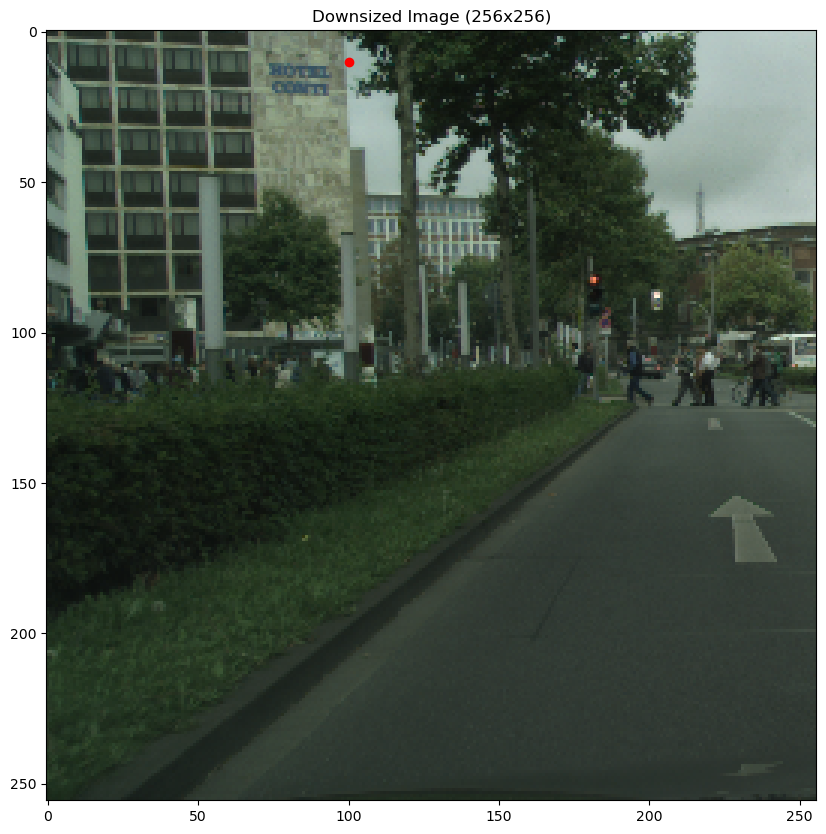

In [16]:
downsized_pixel = (pixel[0] // downsample_factor, pixel[1] // downsample_factor)

# downsize numpy image by 4
downsized_array = image[::4, ::4]


# Plot the downsized image
plt.figure(figsize=(10, 10))
plt.imshow(downsized_array)

plt.scatter(downsized_pixel[0], downsized_pixel[1], c='red', marker='o')

plt.title('Downsized Image (256x256)')
plt.show()


patch index (6, 0)
patch idx 0 pixel inside patch (0, 0)
atten patch (256, 256)
atten for pixel 0
atten for pixel (256,)
atten for pixel (16, 16)


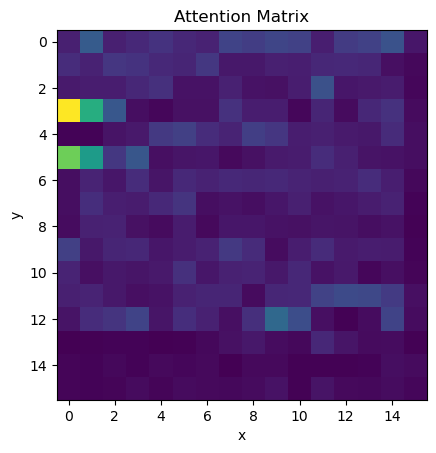

In [17]:
patch_index = (downsized_pixel[0] // 16, downsized_pixel[1] // 16)
print('patch index', patch_index)

# multiply patch_index[0] and patch_index[1] to get the grid number of the patch

patch_idx = patch_index[0]*patch_index[1]
pixel_inside_patch = (((pixel[0] % 4) % 16), ((pixel[1] % 4) % 16))
print('patch idx', patch_idx, 'pixel inside patch', pixel_inside_patch)

# get atten for the patch

atten_patch = atten[patch_idx-1]
print('atten patch', atten_patch.shape)

atten_for_pixel = pixel_inside_patch[0]*pixel_inside_patch[1]
print('atten for pixel', atten_for_pixel)

atten_for_pixel = atten_patch[atten_for_pixel]
print('atten for pixel', atten_for_pixel.shape)

# reshape to 16 16
atten_for_pixel = atten_for_pixel.reshape(16, 16)
print('atten for pixel', atten_for_pixel.shape)

# plot the attention matrix
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Attention Matrix')
ax.imshow(atten_for_pixel, cmap='viridis')
plt.show()


28 18:50:51 WRN Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


atten for pixel rgb (16, 16, 3)


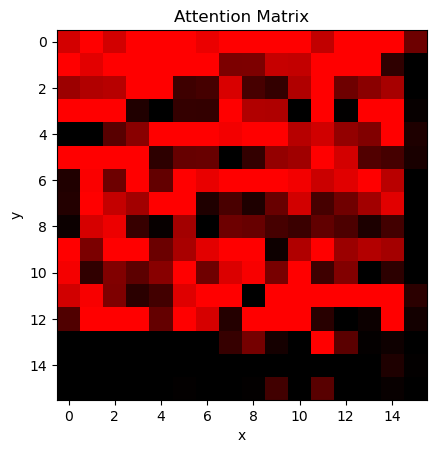

In [18]:
# Create an empty three-channel array
atten_for_pixel_rgb = np.zeros((16, 16, 3))

# Copy the single-channel data into each channel
atten_for_pixel_rgb[:, :, 0] = atten_for_pixel
# atten_for_pixel_rgb[:, :, 1] = atten_for_pixel
# atten_for_pixel_rgb[:, :, 2] = atten_for_pixel

# normalize by mean and std
atten_for_pixel_rgb = (atten_for_pixel_rgb - np.mean(atten_for_pixel_rgb)) / np.std(atten_for_pixel_rgb)

print('atten for pixel rgb', atten_for_pixel_rgb.shape)
# plot the attention matrix
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Attention Matrix')
ax.imshow(atten_for_pixel_rgb)
plt.show()

28 18:51:21 WRN Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


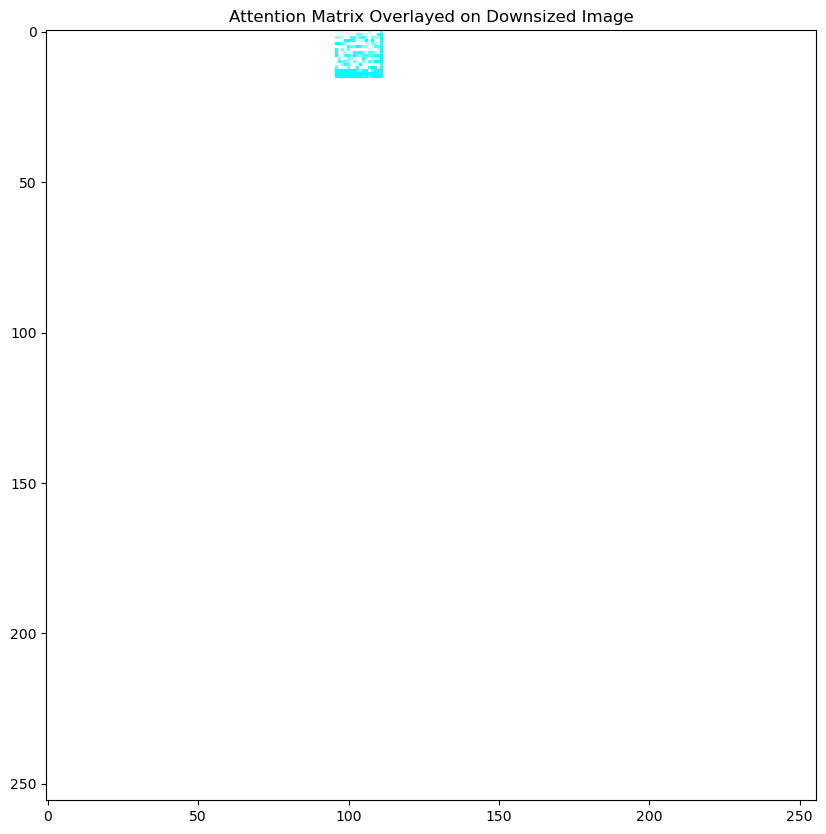

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# # Sample downsized_array (replace this with your actual data)
downsized_array = np.ones((256, 256, 3))

# Create a 16x16 array of ones for atten_for_pixel
# atten_for_pixel = np.ones((16, 16))

# Determine the starting pixel position for the attention plot
start_pixel_x = patch_index[1] * 16
start_pixel_y = patch_index[0] * 16

# Create a copy of the downsized_array to overlay the attention plot on each channel
overlayed_array = downsized_array.copy()

# Overlay the atten_for_pixel on each channel
overlayed_array[start_pixel_x:start_pixel_x+16, start_pixel_y:start_pixel_y+16, 0] = atten_for_pixel_rgb[:,:, 0]

# Plot the downsized_array
plt.figure(figsize=(10, 10))
plt.imshow(downsized_array)
plt.title('Downsized Image')

# Plot the atten_for_pixel on top of the downsized_array
plt.imshow(overlayed_array, alpha=1)

plt.title('Attention Matrix Overlayed on Downsized Image')
plt.show()
